### compare v1.5, v1.7

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
plt.style.use('seaborn')
plt.rc('legend', fontsize=20) # using a size in points
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rcParams['axes.facecolor'] = "w"

#plt.rcParams['axes.labelsize'] = 16
#plt.rcParams['axes.titlesize'] = 16



In [10]:
# load opsim database
dbpath_v1_5 = "/home/idies/workspace/lsst_cadence/FBS_1.5/"  # path to all opsim databases
dbpath_v1_7 = "/home/idies/workspace/lsst_cadence/FBS_1.7/"  # path to all opsim databases
dbpath_v1_7_1 = "/home/idies/workspace/lsst_cadence/FBS_1.7.1/"  # path to all opsim databases


In [4]:
# get the name of all opsim dbs
workpath = os.getcwd()
os.chdir(dbpath_v1_5)  # change to opsim database directory
dblist_all_v1_5 = glob.glob('*.db') 
dblist_all_v1_5.sort()

os.chdir(dbpath_v1_7)  # change to opsim database directory
dblist_all_v1_7 = glob.glob('*.db') 
dblist_all_v1_7.sort()

os.chdir(dbpath_v1_7_1)  # change to opsim database directory
dblist_all_v1_7_1 = glob.glob('*.db') 
dblist_all_v1_7_1.sort()

dblist_all_v1_7_1 = [x.replace('v1.7.1', 'v1.7').replace('v1.7', 'v1.7.1') for x in dblist_all_v1_7_1]


os.chdir(workpath) # change back to work directory



In [5]:
dblist_all_v1_7_1

['baseline_nexp2_v1.7.1_10yrs.db',
 'bulge_roll_scale0.90_nslice2_fpw0.9_nrw1.0v1.7.1_10yrs.db',
 'bulge_roll_scale0.90_nslice3_fpw0.9_nrw1.0v1.7.1_10yrs.db',
 'footprint_6_v1.7.1_10yrs.db',
 'full_disk_scale0.90_nslice2_fpw0.9_nrw1.0v1.7.1_10yrs.db',
 'full_disk_scale0.90_nslice3_fpw0.9_nrw1.0v1.7.1_10yrs.db',
 'full_disk_v1.7.1_10yrs.db',
 'rolling_nm_scale0.90_nslice2_fpw0.9_nrw1.0v1.7.1_10yrs.db',
 'rolling_nm_scale0.90_nslice3_fpw0.9_nrw1.0v1.7.1_10yrs.db',
 'six_stripe_scale0.90_nslice6_fpw0.9_nrw0.0v1.7.1_10yrs.db']

In [6]:
def scale(arr, mode=0, fmax=1):
    """scale array by max, or given fmax"""
    
    newarr = arr / arr.max()
    if mode==1:
        # scale to 0-1
        newarr = (arr - arr.min()) / (arr.max()-arr.min())
    elif mode==2:
        # scale input max
        newarr = arr / fmax
        
    return newarr

def get_family(df):
    """get family of opsim"""
    
    return df['db'].split('_')[0]



In [7]:
def get_df_norm(df=[], cols=['u'], fomcsv = 'df_tgapsFoM_GP.csv', mode=0, fmax=1):
    """
    Input: dataframe or csvfile
    return normalized dataframe
    cols: columns to normalize
    """
    
    if len(df)!=0:
        df_fom = df.copy()
    else:
        df_fom = pd.read_csv(fomcsv)
    
    if 'db' not in df_fom.columns:
        df_fom['db'] = dblist_all
        
    # scale fom table to 0 and 1
    if 'prop' in df_fom.columns:
        df_new = df_fom[ ['db', 'prop'] ].copy()
    else:
        df_new = df_fom[ ['db'] ].copy()
    
    for col in cols:
        # df_new[ col ] = np.tanh ( scale ( df_fom[col] ) * 3 )
        df_new[col] = scale(df_fom[col], mode=mode, fmax=fmax) 
        
    df_new['db'] = df_new['db'].apply(lambda x: x.replace(".db", "") )

    df_new['db'] = df_new['db'].apply(lambda x: x.replace("_v1.5_10yrs", "") )
    df_new['db'] = df_new['db'].apply(lambda x: x.replace("v1.5_10yrs", "") )
    
    df_new['db'] = df_new['db'].apply(lambda x: x.replace("_10yrs", "") )
    df_new['db'] = df_new['db'].apply(lambda x: x.replace("10yrs", "") )

    df_new['family'] = df_new.apply(get_family, axis=1)
    
    return df_new




In [9]:
def plot_barh_v3(df_new, colon, byfamily=True, savefig=None, figsize=(8, 30), facecolor="#f1f1f3", title='', **kwargs):
    """barh plot of FoM"""
    from matplotlib.patches import Patch

    df_ = df_new.copy()
    df_['total'] = np.sum(df_[ colon ], axis=1)
    
    # get the max FOM of each family and sort by this
    df_mean_family = df_.groupby(by = "family", as_index=False).max()[['family', 'total']]
    df_ = df_.merge(df_mean_family, on='family', how='left', suffixes=['', '_fmean'],)
    
    df_ = df_.set_index('db')
    if byfamily:
        df_ = df_.sort_values(by=['total_fmean', 'total'], ascending=[True, True])
    else:
        # sort by total only
        df_ = df_.sort_values(by='total', ascending=True)
    
    df_[colon] = df_[colon]/len(colon)
    ax = df_[ colon ].plot.barh(stacked=True, figsize=figsize, **kwargs)
    
    # get positions of hlines
    if byfamily:
        hlines = df_.groupby(by='family', as_index=False, sort=False).count().cumsum()['total_fmean'].values - 0.5
        hlines = [hlines, hlines]
        ax.plot((-0.5, 1), hlines, 'k-', linewidth=1, alpha=0.5)
    
    plt.xlabel('normalized score', fontsize=20)
    plt.ylabel('')
    #plt.legend(loc='lower right', frameon=True)
    plt.xlim([0,1.01])
    
    #ax = plt.gca()
    ax.set_facecolor(facecolor)
    ax.set_title(title)
    
    #for i, patch in enumerate(ax.patches):
    #    if i in [10,20]:
    #        patch.set_color('black')
    
    # modify labels
    #for tl in ax.get_yticklabels():
    #    txt = tl.get_text()
    #    if 'v1.7' in txt:
            #txt += ' (!)'
            #tl.set_backgroundcolor('C3')
            #tl.set_backgroundcolor("#FF9398")
    #        tl.set_backgroundcolor("#E5E7E9")
    #    if 'baseline' in txt:
            #tl.set_backgroundcolor("#FF9398")
    #        tl.set_fontweight('bold') 
            
    #    #tl.set_text(txt)
    #cmap = plt.cm.get_cmap('plasma')
    #colors = [cmap(i) for i in np.linspace(0, 1, 4)][:4]
    colors = [(0.050383, 0.029803, 0.527975, 0.65),
              (0.610667, 0.090204, 0.619951, 0.65),
              ( 0.928329, 0.472975, 0.326067, 0.65),
              (0.940015, 0.975158, 0.131326, 0.65)]
    
    color0 = 'indianred'
    color1 = colors[2]
    color2 = 'steelblue'
    yticklabels = []
    for i, (patch, tl) in enumerate( zip(ax.patches[:170], ax.get_yticklabels() ) ):
        txt = tl.get_text()
        for pi in [i+170*j for j in range(5)]:
            p = ax.patches[pi]
             
            if 'v1.7.1' in txt:
                p.set_color(color0)
                yticklabels.append( txt.replace('_v1.7.1', '').replace('v1.7.1', '') )
            
              
            elif 'v1.7' in txt:
                p.set_color(color1) 
                yticklabels.append( txt.replace('_v1.7', '').replace('v1.7', '') )

            else:
                p.set_color(color2)
                yticklabels.append(txt)
                
            p.set_linewidth(0.1)
            p.set_edgecolor('black')
                        
        if 'baseline' in txt:
            #tl.set_backgroundcolor("#FF9398")
            tl.set_fontweight('bold') 
    
    ax.set_yticklabels(yticklabels[0:170*5:5])
    
    # create legend
    legend_elements = [ Patch(facecolor=color0, edgecolor='k',
                         label='OpSim v1.7.1'),
                        Patch(facecolor=color1, edgecolor='k',
                         label='OpSim v1.7'),
                        Patch(facecolor=color2, edgecolor='k',
                         label='OpSim v1.5')]
              
    ax.legend(handles=legend_elements, loc='lower right', fontsize=40, facecolor='w', frameon=True)

    if savefig!=None:
        plt.savefig(savefig, bbox_inches='tight')
    
    return ax



### prepare concat df_radar

In [25]:
# for proposalId=1 wfd

#df_tgaps_v1_5 = pd.read_csv('./data/df_tgaps_log_v1.5_WFD.csv')
#df_nfields_v1_5 = pd.read_csv('./data/df_Nfields_2d_v1.5_WFD.csv')
#df_nstars_v1_5 = pd.read_csv('./data/df_Nstars_2d_v1.5_WFD.csv')
#df_depth_v1_5 = pd.read_csv('./data/df_depth_v1.5_WFD.csv')
#
#df_tgaps_v1_7 = pd.read_csv('./data/df_tgaps_log_v1.7_WFD.csv')
#df_nfields_v1_7 = pd.read_csv('./data/df_Nfields_2d_v1.7_WFD.csv')
#df_nstars_v1_7 = pd.read_csv('./data/df_Nstars_2d_v1.7_WFD.csv')
#df_depth_v1_7 = pd.read_csv('./data/df_depth_v1.7_WFD.csv')
#
#df_tgaps_v1_7_1 = pd.read_csv('./data/df_tgaps_log_v1.7.1_WFD.csv')
#df_nfields_v1_7_1 = pd.read_csv('./data/df_Nfields_2d_v1.7.1_WFD.csv')
#df_nstars_v1_7_1 = pd.read_csv('./data/df_Nstars_2d_v1.7.1_WFD.csv')
#df_depth_v1_7_1 = pd.read_csv('./data/df_depth_v1.7.1_WFD.csv')


# for all


#df_tgaps_v1_5 = pd.read_csv('./data/df_tgaps_log_v1.5_ALL.csv')
#df_nfields_v1_5 = pd.read_csv('./data/df_Nfields_2d_v1.5_ALL.csv')
#df_nstars_v1_5 = pd.read_csv('./data/df_Nstars_2d_v1.5_ALL.csv')
#df_depth_v1_5 = pd.read_csv('./data/df_depth_v1.5_ALL.csv')
#
#df_tgaps_v1_7 = pd.read_csv('./data/df_tgaps_log_v1.7_ALL.csv')
#df_nfields_v1_7 = pd.read_csv('./data/df_Nfields_2d_v1.7_ALL.csv')
#df_nstars_v1_7 = pd.read_csv('./data/df_Nstars_2d_v1.7_ALL.csv')
#df_depth_v1_7 = pd.read_csv('./data/df_depth_v1.7_ALL.csv')
#
#df_tgaps_v1_7_1 = pd.read_csv('./data/df_tgaps_log_v1.7.1_ALL.csv')
#df_nfields_v1_7_1 = pd.read_csv('./data/df_Nfields_2d_v1.7.1_ALL.csv')
#df_nstars_v1_7_1 = pd.read_csv('./data/df_Nstars_2d_v1.7.1_ALL.csv')
#df_depth_v1_7_1 = pd.read_csv('./data/df_depth_v1.7.1_ALL.csv')



In [48]:
# reduce for v1.5 number of visits by 0.09

# for proposalId=1 wfd

#df_tgaps_v1_5 = pd.read_csv('./data/df_tgaps_log_v1.5_WFD_reduced.csv')
#df_nfields_v1_5 = pd.read_csv('./data/df_Nfields_2d_v1.5_WFD_reduced.csv')
#df_nstars_v1_5 = pd.read_csv('./data/df_Nstars_2d_v1.5_WFD_reduced.csv')
#df_depth_v1_5 = pd.read_csv('./data/df_depth_v1.5_WFD.csv')
#
#df_tgaps_v1_7 = pd.read_csv('./data/df_tgaps_log_v1.7_WFD.csv')
#df_nfields_v1_7 = pd.read_csv('./data/df_Nfields_2d_v1.7_WFD.csv')
#df_nstars_v1_7 = pd.read_csv('./data/df_Nstars_2d_v1.7_WFD.csv')
#df_depth_v1_7 = pd.read_csv('./data/df_depth_v1.7_WFD.csv')
#
#df_tgaps_v1_7_1 = pd.read_csv('./data/df_tgaps_log_v1.7.1_WFD.csv')
#df_nfields_v1_7_1 = pd.read_csv('./data/df_Nfields_2d_v1.7.1_WFD.csv')
#df_nstars_v1_7_1 = pd.read_csv('./data/df_Nstars_2d_v1.7.1_WFD.csv')
#df_depth_v1_7_1 = pd.read_csv('./data/df_depth_v1.7.1_WFD.csv')


# for all


df_tgaps_v1_5 = pd.read_csv('./data/df_tgaps_log_v1.5_ALL_reduced.csv')
df_nfields_v1_5 = pd.read_csv('./data/df_Nfields_2d_v1.5_ALL_reduced.csv')
df_nstars_v1_5 = pd.read_csv('./data/df_Nstars_2d_v1.5_ALL_reduced.csv')
df_depth_v1_5 = pd.read_csv('./data/df_depth_v1.5_ALL.csv')

df_tgaps_v1_7 = pd.read_csv('./data/df_tgaps_log_v1.7_ALL.csv')
df_nfields_v1_7 = pd.read_csv('./data/df_Nfields_2d_v1.7_ALL.csv')
df_nstars_v1_7 = pd.read_csv('./data/df_Nstars_2d_v1.7_ALL.csv')
df_depth_v1_7 = pd.read_csv('./data/df_depth_v1.7_ALL.csv')

df_tgaps_v1_7_1 = pd.read_csv('./data/df_tgaps_log_v1.7.1_ALL.csv')
df_nfields_v1_7_1 = pd.read_csv('./data/df_Nfields_2d_v1.7.1_ALL.csv')
df_nstars_v1_7_1 = pd.read_csv('./data/df_Nstars_2d_v1.7.1_ALL.csv')
df_depth_v1_7_1 = pd.read_csv('./data/df_depth_v1.7.1_ALL.csv')




In [49]:
filters = ['u', 'g', 'r', 'i', 'z', 'y']
cols_all = ['uu', 'ug', 'ur', 'ui', 'uz', 'uy', 'gg', 'gr', 'gi', 'gz', 'gy', 'rr', 'ri', 'rz', 'ry', 'ii', 'iz', 'iy', 'zz', 'zy', 'yy']

cols_same = [ 'uu',  'gg',  'rr',  'ii',  'zz',  'yy']

cols_diff = ['ug', 'ur', 'ui', 'uz', 'uy', 'gr', 'gi', 'gz', 'gy', 'ri', 'rz', 'ry', 'iz', 'iy', 'zy']



In [27]:

def df_concat( df_v1_5, df_v1_7, df_v1_7_1 ):

    df_v1_5['db'] = dblist_all_v1_5
    df_v1_5['version'] = 'v1_5'

    df_v1_7['db'] = dblist_all_v1_7
    df_v1_7['version'] = 'v1_7'
    
    #df = pd.concat([df_v1_5, df_v1_7])


    df_v1_7_1['db'] = dblist_all_v1_7_1
    df_v1_7_1['version'] = 'v1_7_1'
    df = pd.concat([df_v1_5, df_v1_7, df_v1_7_1], sort=False)

    return df


In [15]:
dblist_all_v1_7_1

['baseline_nexp2_v1.7.1_10yrs.db',
 'bulge_roll_scale0.90_nslice2_fpw0.9_nrw1.0v1.7.1_10yrs.db',
 'bulge_roll_scale0.90_nslice3_fpw0.9_nrw1.0v1.7.1_10yrs.db',
 'footprint_6_v1.7.1_10yrs.db',
 'full_disk_scale0.90_nslice2_fpw0.9_nrw1.0v1.7.1_10yrs.db',
 'full_disk_scale0.90_nslice3_fpw0.9_nrw1.0v1.7.1_10yrs.db',
 'full_disk_v1.7.1_10yrs.db',
 'rolling_nm_scale0.90_nslice2_fpw0.9_nrw1.0v1.7.1_10yrs.db',
 'rolling_nm_scale0.90_nslice3_fpw0.9_nrw1.0v1.7.1_10yrs.db',
 'six_stripe_scale0.90_nslice6_fpw0.9_nrw0.0v1.7.1_10yrs.db']

In [50]:
df_tgaps = df_concat(df_tgaps_v1_5, df_tgaps_v1_7, df_tgaps_v1_7_1 )
df_nfields = df_concat(df_nfields_v1_5, df_nfields_v1_7, df_nfields_v1_7_1)
df_nstars = df_concat(df_nstars_v1_5, df_nstars_v1_7, df_nstars_v1_7_1 )
df_depth = df_concat(df_depth_v1_5, df_depth_v1_7, df_depth_v1_7_1)

In [51]:
# normalize
for col in cols_all:
    # df_new[ col ] = np.tanh ( scale ( df_fom[col] ) * 3 )
    df_tgaps[col] = scale(df_tgaps[col], mode=0)
    df_nfields[col] = scale(df_nfields[col], mode=2, fmax=1460)
    df_nstars[col] = scale(df_nstars[col], mode=2, fmax=122876537)

for col in filters:
    df_depth[col] = scale(df_depth[col], mode=1)

df_tgaps['total_same'] = scale( np.sum(df_tgaps[ cols_same ], axis=1) )
df_tgaps['total_diff'] = scale( np.sum(df_tgaps[ cols_diff ], axis=1) )
df_nfields['total'] = scale( np.sum(df_nfields[ cols_all ], axis=1) )
df_nstars['total'] = scale( np.sum(df_nstars[ cols_all ], axis=1) )
df_depth['total'] = scale( np.sum(df_depth[ filters ], axis=1) )



In [52]:
msname = 'v1.5_v1.7_v1.7.1_ALL_reduced'
#msname = 'all_v1_5_v1_7'
#msname = 'all_v1_5_v1_7_reduced'

df_radar = pd.DataFrame()
df_radar['db'] = df_nfields['db']

df_radar['flux change'] = df_tgaps['total_same']
df_radar['color'] = df_tgaps['total_diff'] 

df_radar['footprint'] = df_nfields['total']
df_radar['star count'] = df_nstars['total']
df_radar['depth'] = df_depth['total']
df_radar['family'] = df_radar.apply(get_family, axis=1)

# save file 
df_radar.to_csv('./data/df_radar_{}.csv'.format(msname), index=False)

In [21]:
FoMvars = ['flux change','color', 'depth', 'footprint', 'star count',]



In [22]:
import matplotlib.colors as mcolors
colors = plt.cm.tab10( np.linspace(0., 1, 10) )[:5]
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)



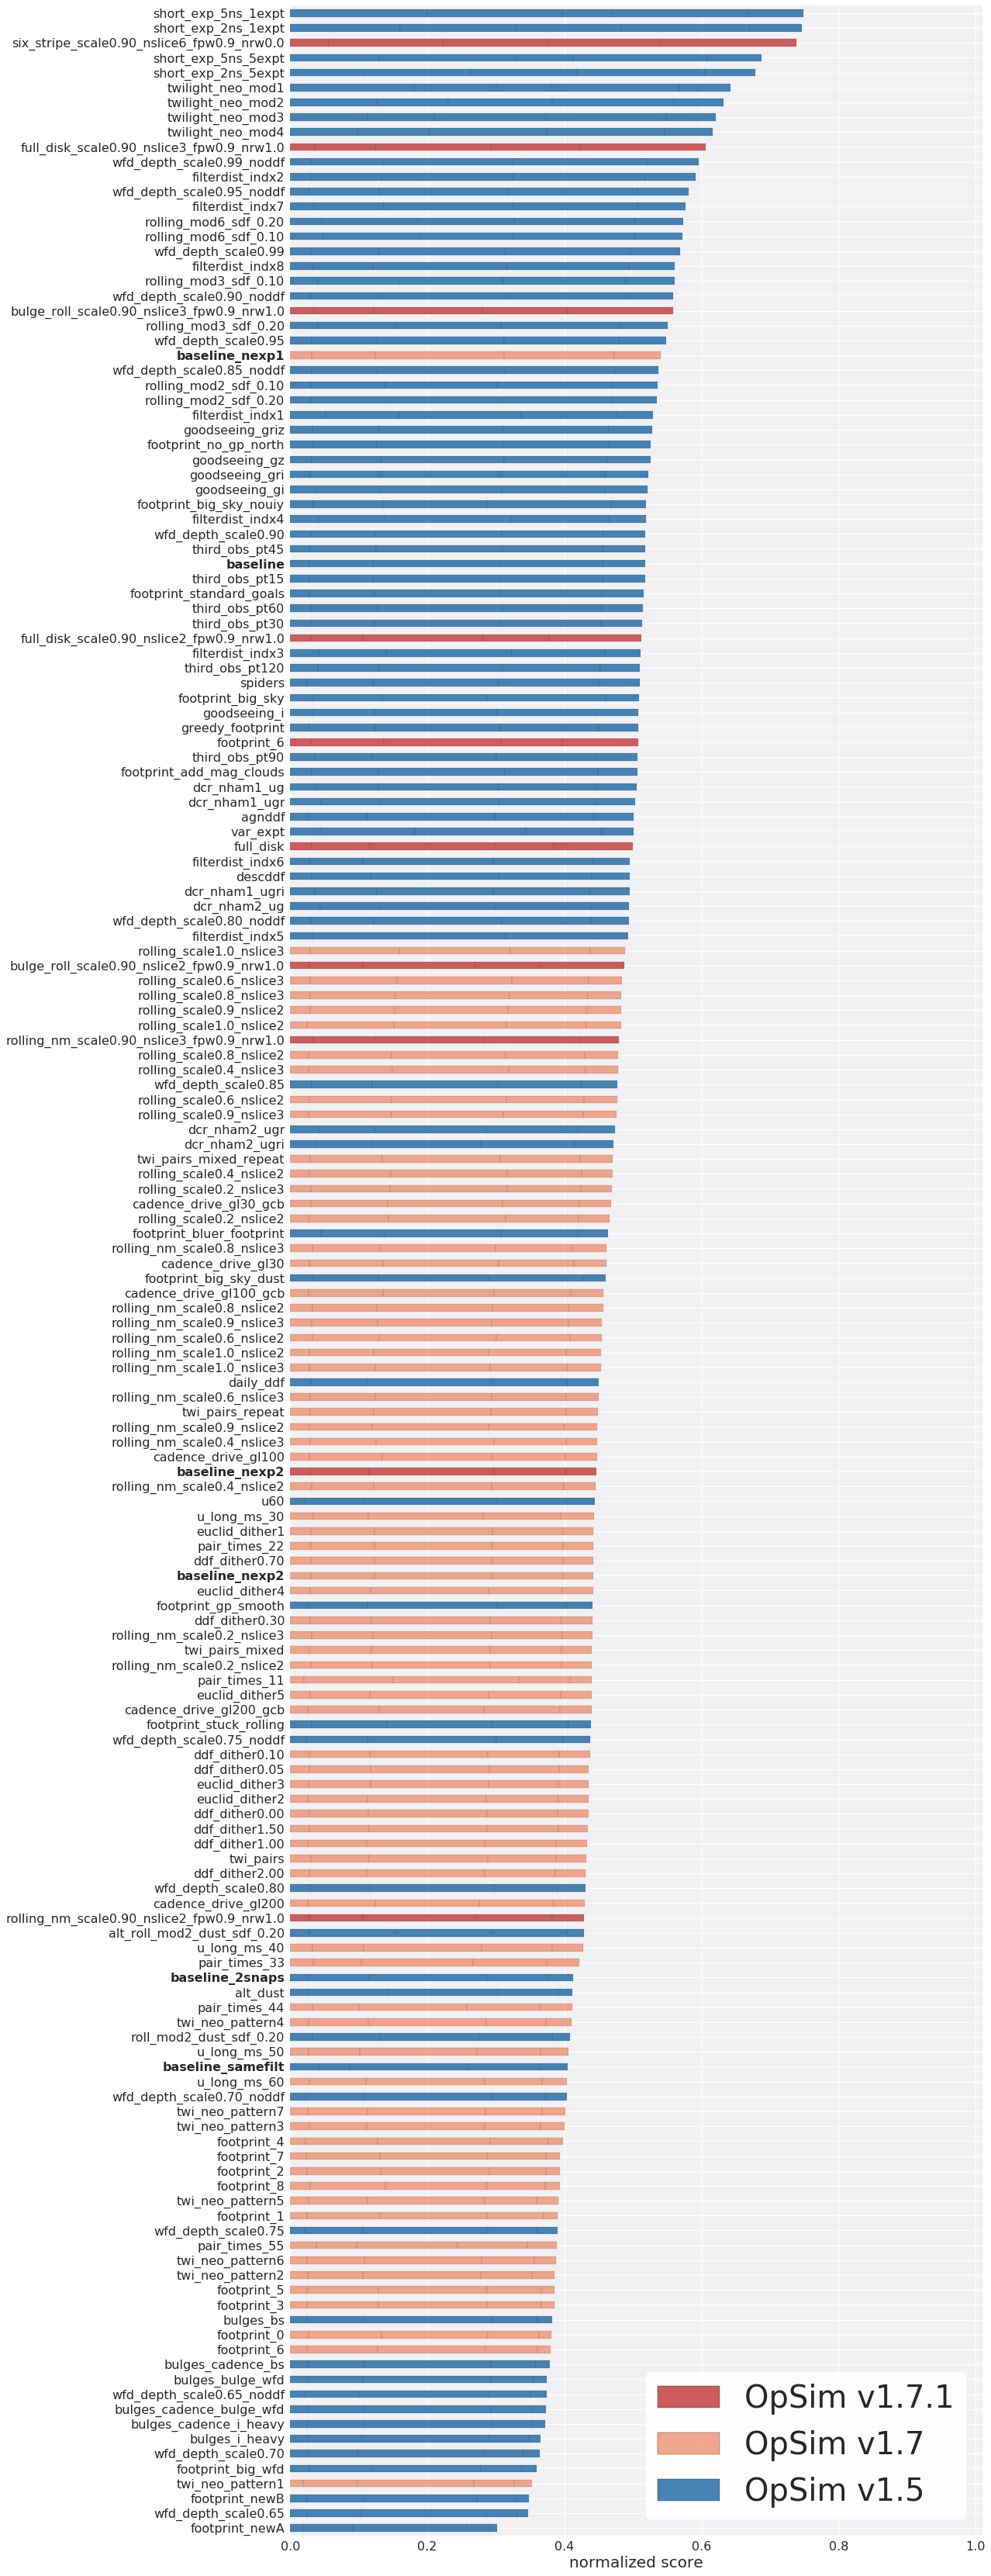

In [23]:
fomcsv = './data/df_radar_v1.5_v1.7_v1.7.1_WFD.csv'
#fomcsv = './data_v1_5/df_Nstars_wfd.csv'

df_norm = get_df_norm(fomcsv=fomcsv, cols=FoMvars)

ax = plot_barh_v3(df_norm, colon=FoMvars, byfamily=False, figsize=(16, 60), savefig='figures/barh_family_all_v1_5_v1_7_v1_7_1.pdf', colormap=mymap ) 




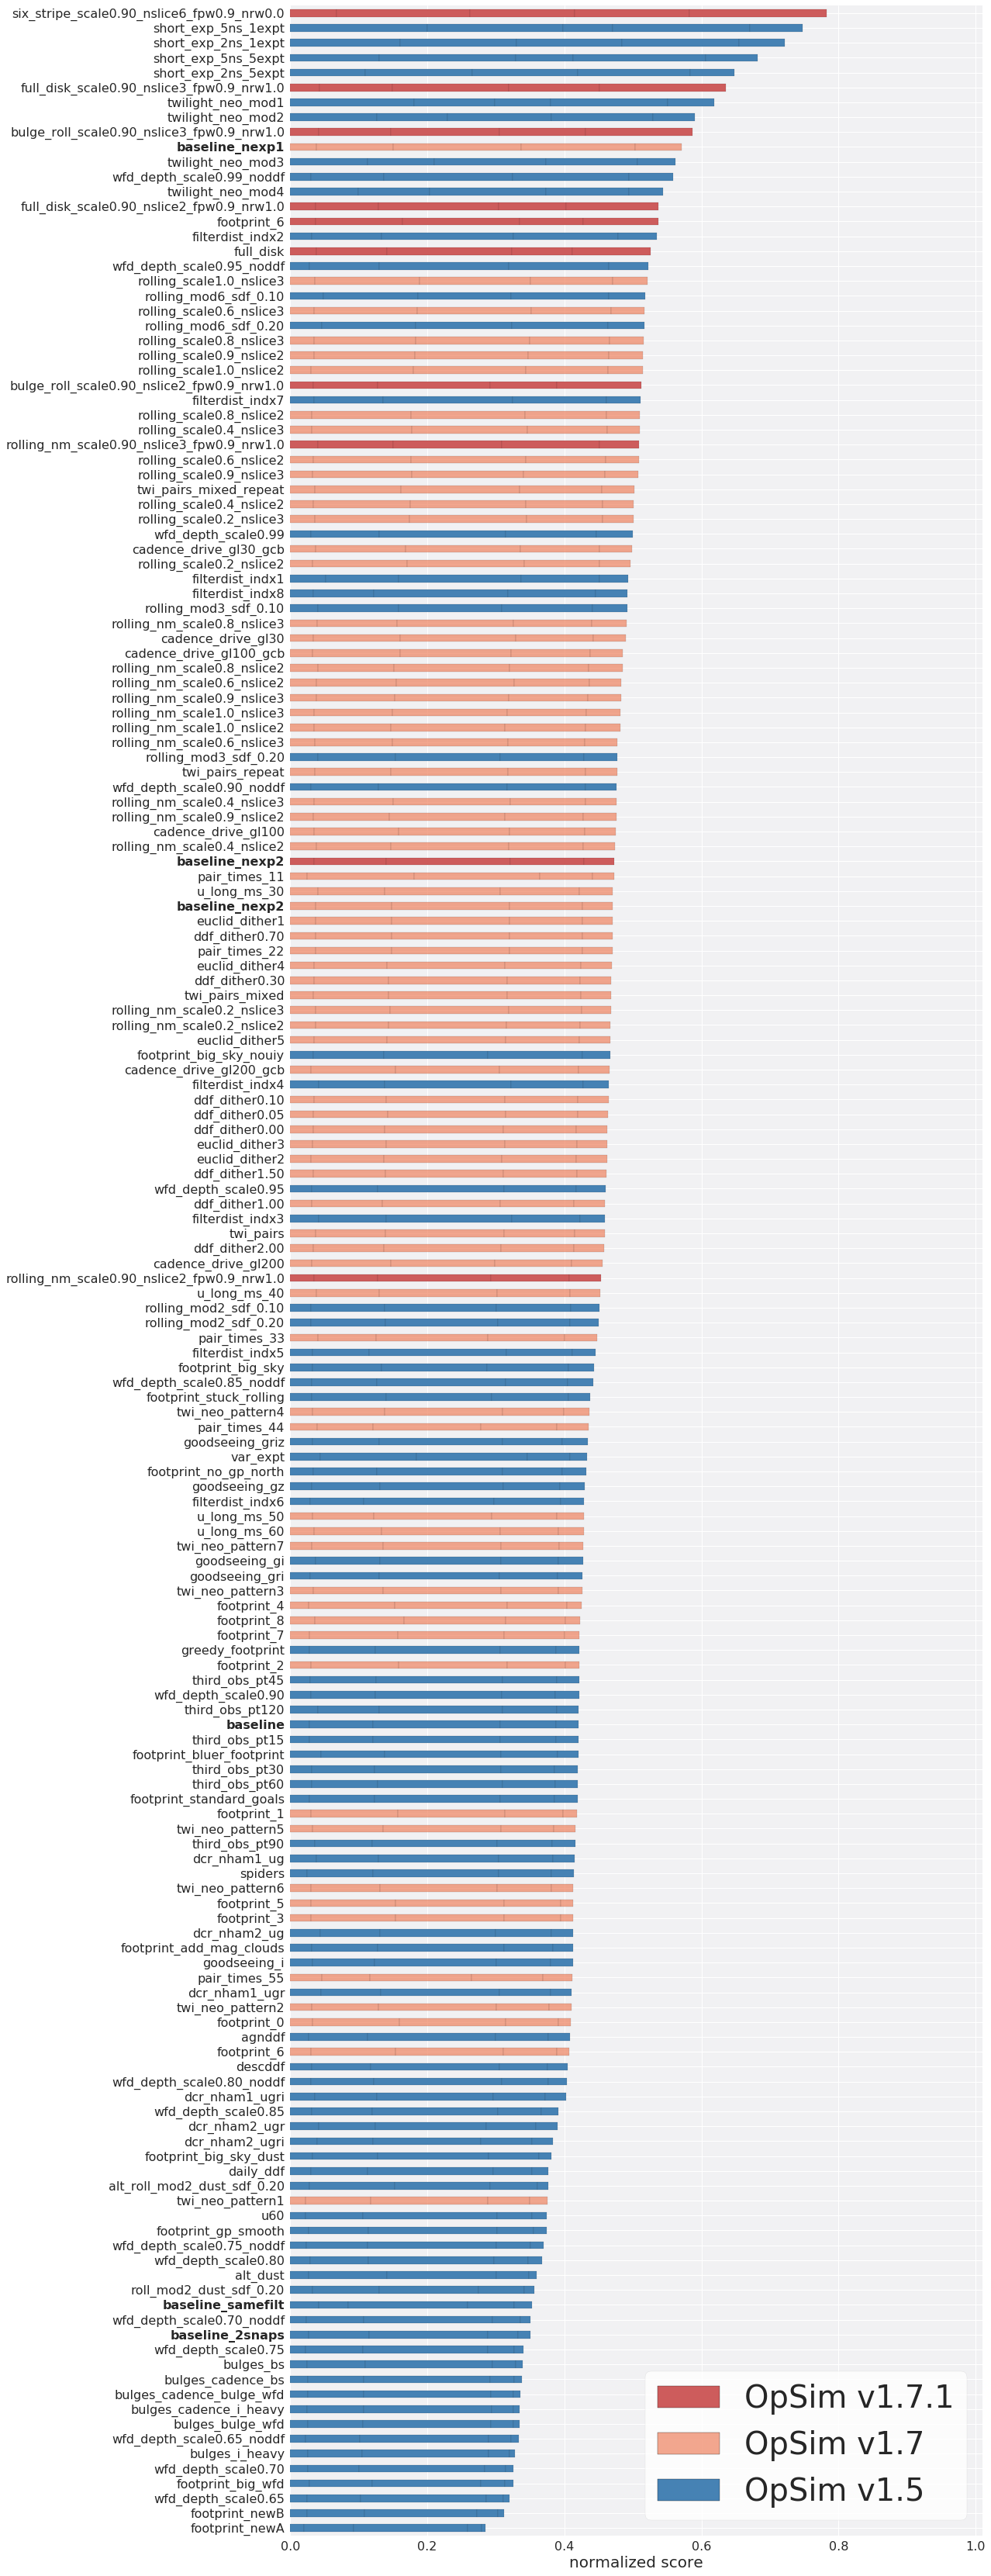

In [47]:
fomcsv = './data/df_radar_v1.5_v1.7_v1.7.1_WFD_reduced.csv'
#fomcsv = './data_v1_5/df_Nstars_wfd.csv'

df_norm = get_df_norm(fomcsv=fomcsv , cols=FoMvars)

ax = plot_barh_v3(df_norm, colon=FoMvars, byfamily=False, figsize=(16, 60), savefig='figures/barh_family_wfd_v1_5_v1_7_reduced.pdf', colormap=mymap ) 




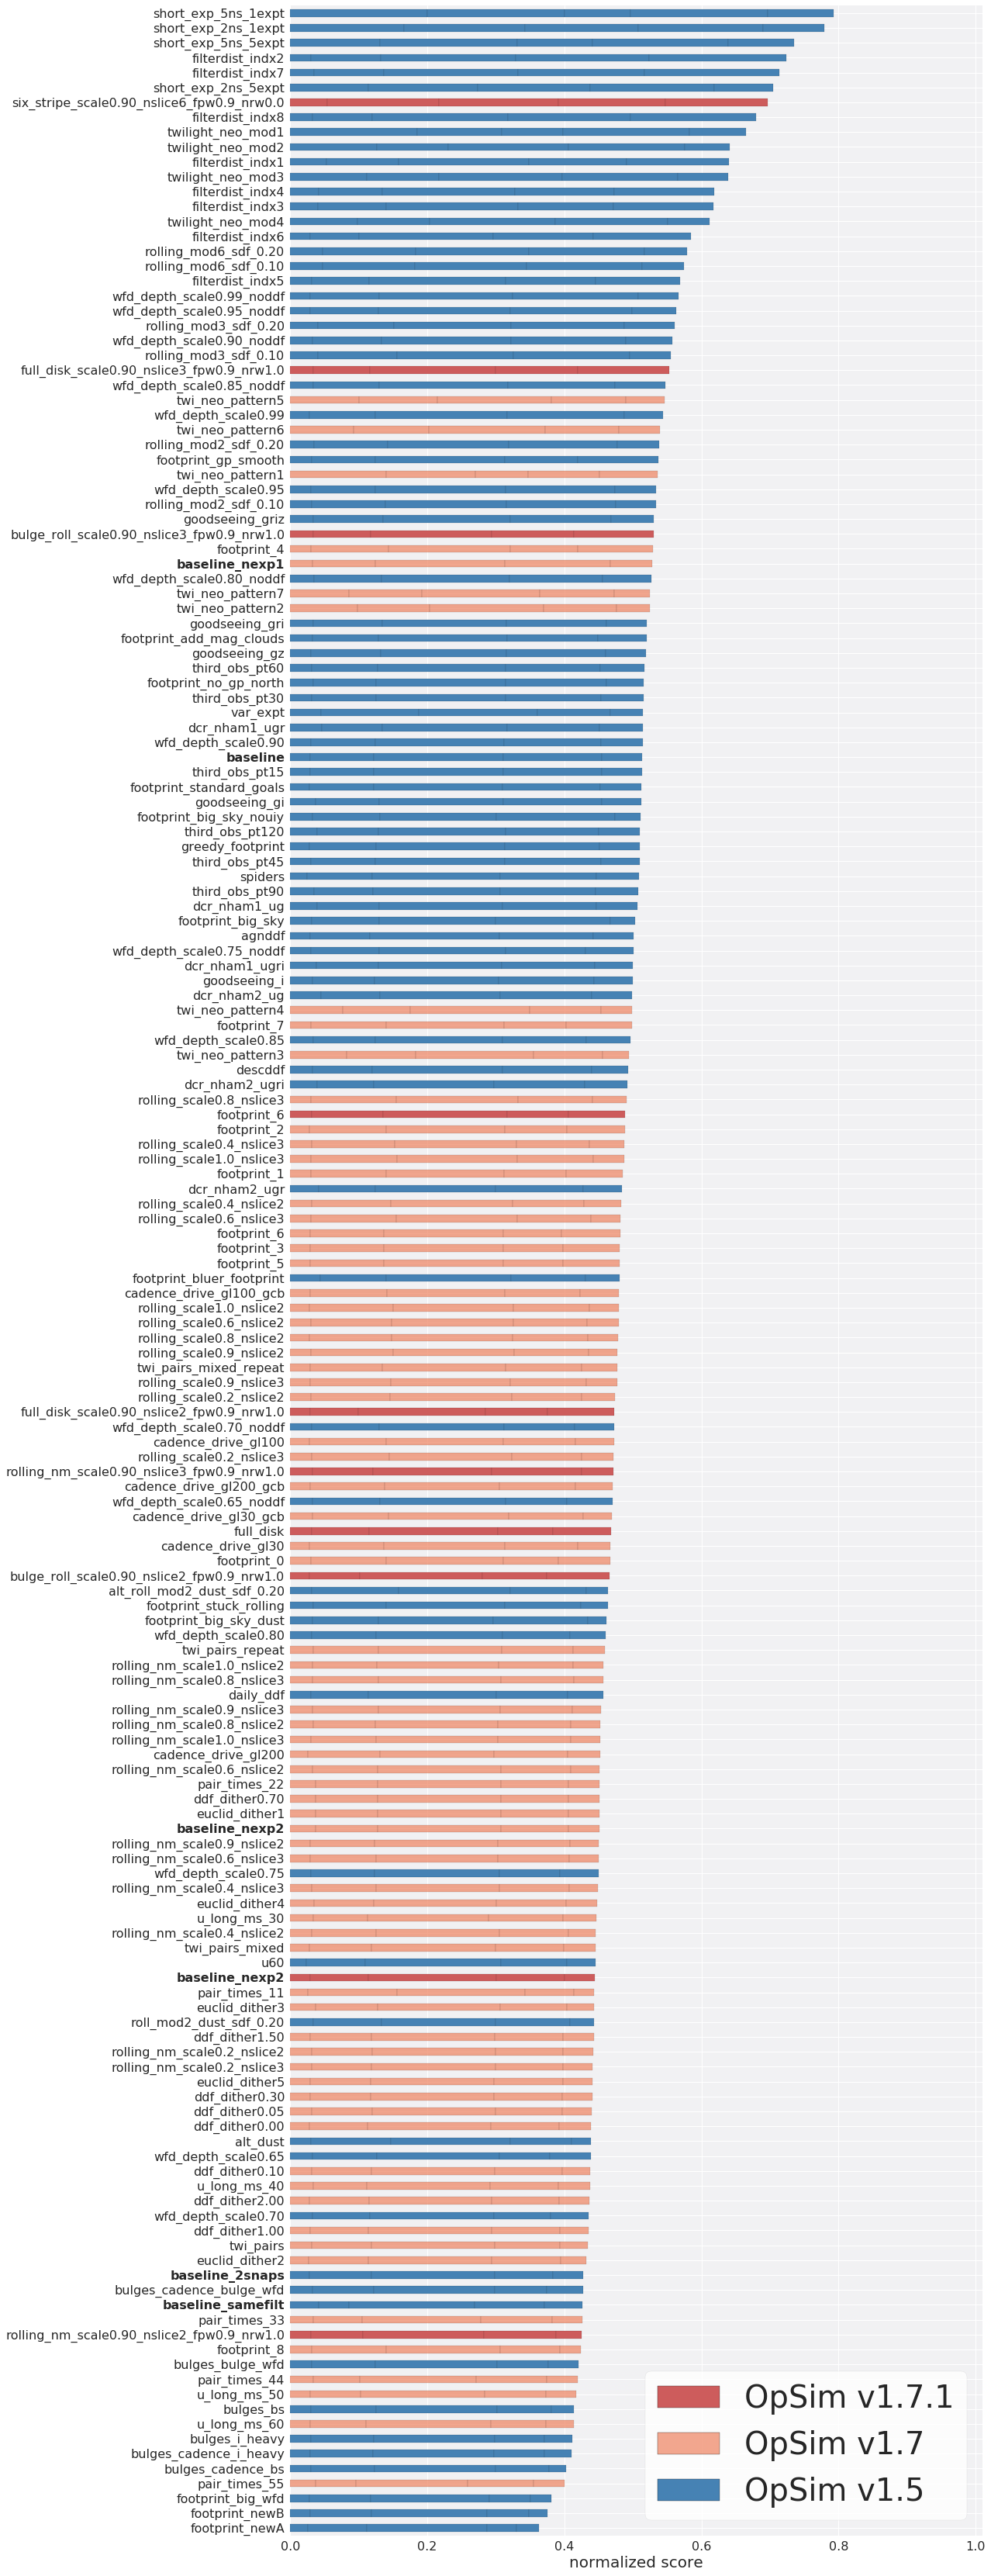

In [44]:
fomcsv = './data/df_radar_v1.5_v1.7_v1.7.1_ALL.csv'
#fomcsv = './data_v1_5/df_Nstars_wfd.csv'

df_norm = get_df_norm(fomcsv=fomcsv, cols=FoMvars)

ax = plot_barh_v3(df_norm, colon=FoMvars, byfamily=False, figsize=(16, 60), savefig='figures/barh_family_all_v1_5_v1_7_v1_7_1.pdf', colormap=mymap ) 




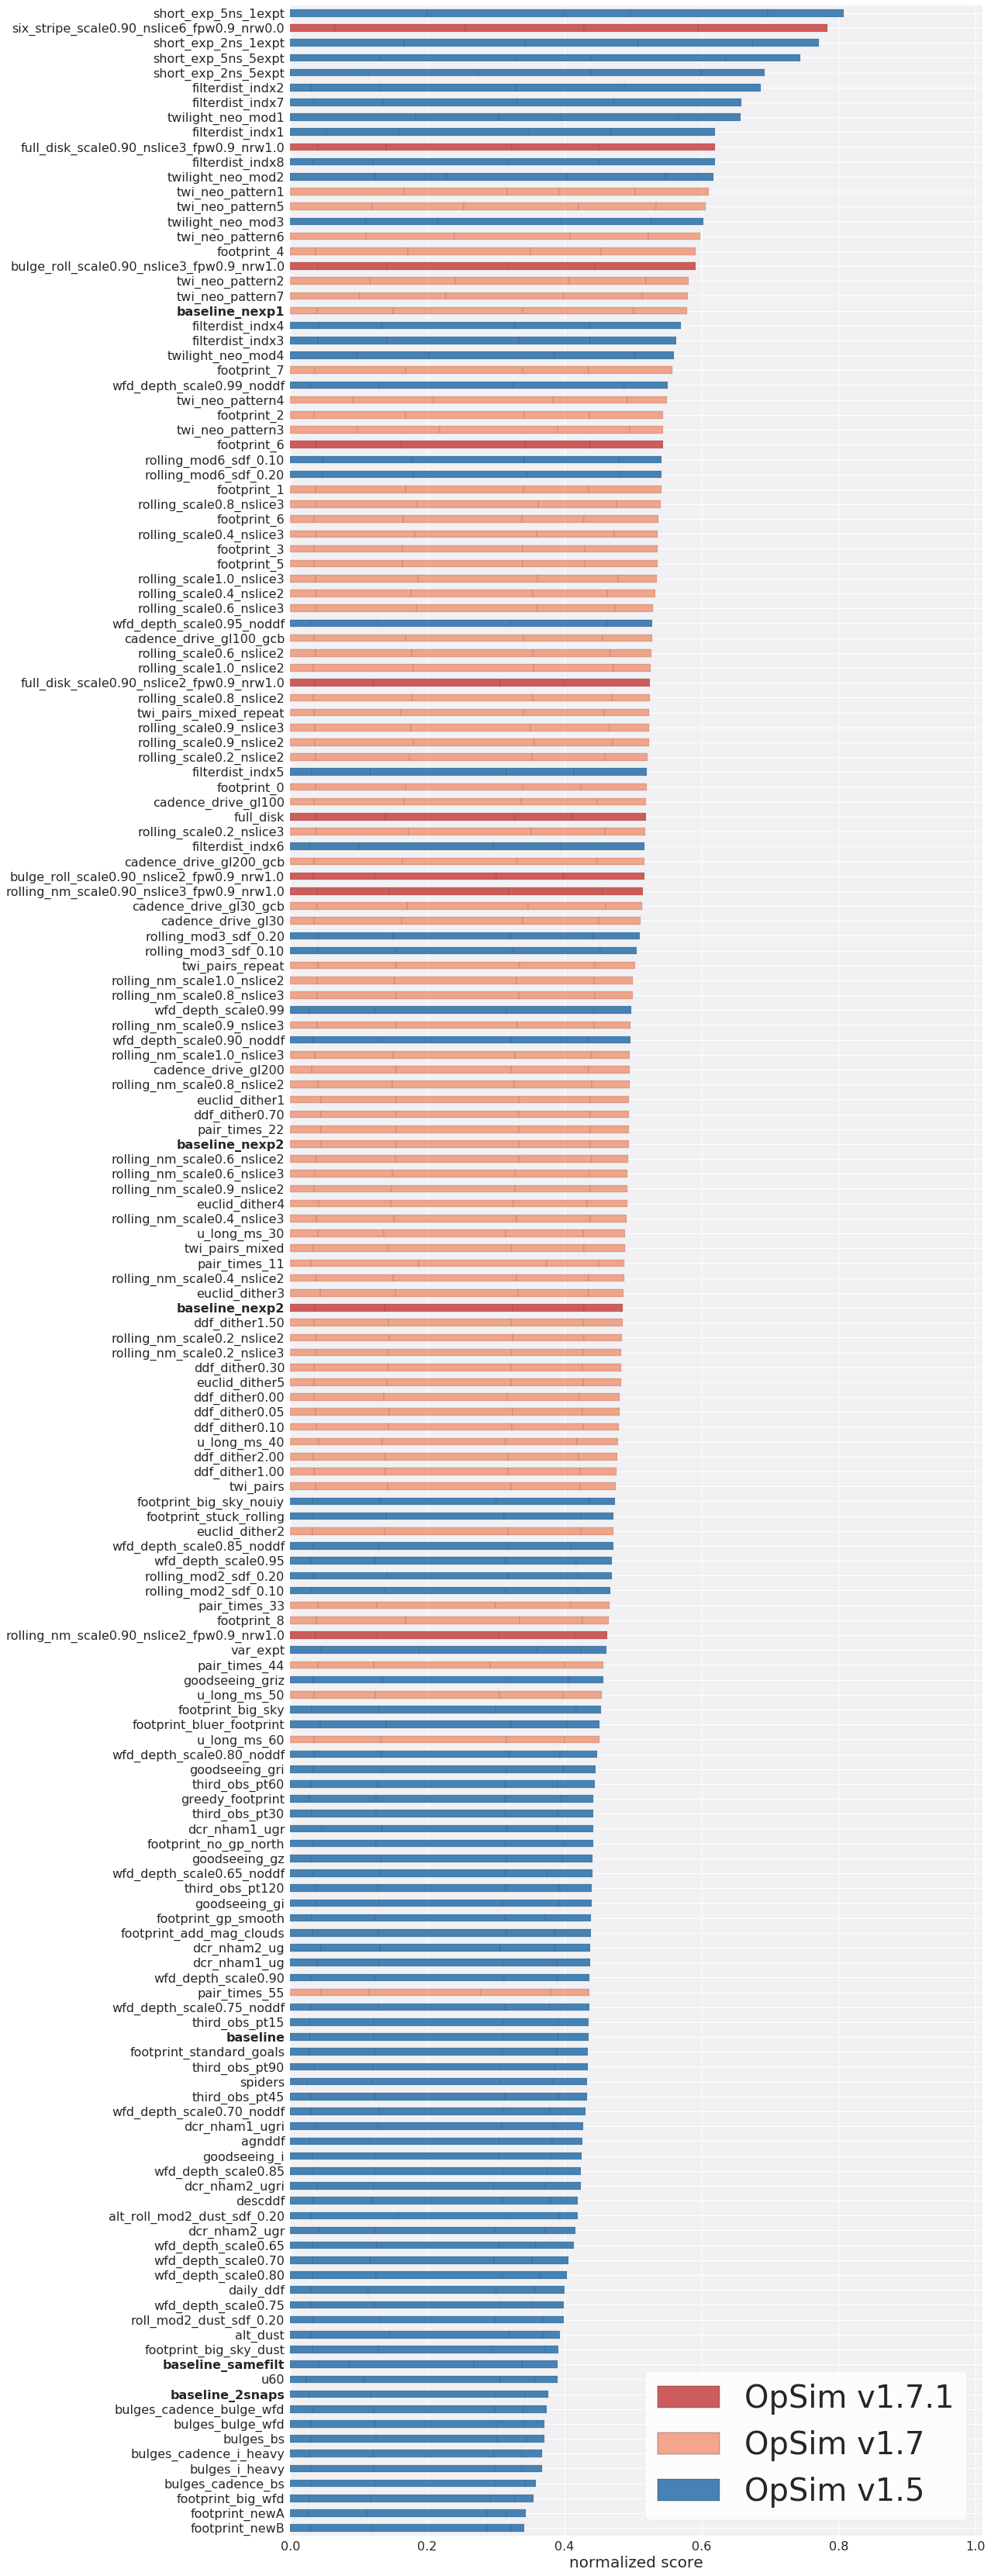

In [53]:
fomcsv = './data/df_radar_v1.5_v1.7_v1.7.1_ALL_reduced.csv'

#fomcsv = './data_v1_5/df_Nstars_wfd.csv'

df_norm = get_df_norm(fomcsv=fomcsv , cols=FoMvars)

ax = plot_barh_v3(df_norm, colon=FoMvars, byfamily=False, figsize=(16, 60), savefig='figures/barh_family_all_v1_5_v1_7.pdf', colormap=mymap ) 

